In [ ]:
import sys
!{sys.executable} -m pip install --upgrade --user pip # update the pip package installer
!{sys.executable} -m pip install -U numpy pandas uproot3 matplotlib --user # install required packages

In [11]:
import pandas as pd # to store data as dataframes
import numpy as np # for numerical calculations such as histogramming
import math # for mathematical functions such as square root
import uproot3 # to read .root files as dataframes
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import AutoMinorLocator # for minor ticks
import infofile # local file containing info on cross-sections, sums of weights, dataset IDs

In [12]:
#lumi = 0.5 # fb-1 # data_A only
#lumi = 1.9 # fb-1 # data_B only
#lumi = 2.9 # fb-1 # data_C only
#lumi = 4.7 # fb-1 # data_D only
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

fraction = 1.0 # reduce this is if you want the code to run quicker
                                                                                                                                  
#tuple_path = "Input/4lep/" # local 
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/1lep1tau/" # web address

In [13]:
samples = {

    'data': {
        'list' : ['data_A','data_B','data_C','data_D'],
    },

    r' $Z \rightarrow \tau \tau$' : { # 
        'list' : ['Ztautau_PTV0_70_CVetoBVeto', 'Ztautau_PTV0_70_CFilterBVeto', 'Ztautau_PTV0_70_BFilter',
                 'Ztautau_PTV70_140_CVetoBVeto', 'Ztautau_PTV70_140_CFilterBVeto', 'Ztautau_PTV70_140_BFilter',
                 'Ztautau_PTV140_280_CVetoBVeto', 'Ztautau_PTV140_280_CFilterBVeto', 'Ztautau_PTV140_280_BFilter',
                 'Ztautau_PTV280_500_CVetoBVeto', 'Ztautau_PTV280_500_CFilterBVeto', 'Ztautau_PTV280_500_BFilter',
                 'Ztautau_PTV500_1000', 'Ztautau_PTV1000_E_CMS'],
        'color' : "#00cdff" # light blue
    },

    r' $Z \rightarrow ee, \mu \mu$' : { #
        'list' : ['Zmumu_PTV0_70_CVetoBVeto', 'Zmumu_PTV0_70_CFilterBVeto', 'Zmumu_PTV0_70_BFilter',
                 'Zmumu_PTV70_140_CVetoBVeto', 'Zmumu_PTV70_140_CFilterBVeto', 'Zmumu_PTV70_140_BFilter',
                 'Zmumu_PTV140_280_CVetoBVeto', 'Zmumu_PTV140_280_CFilterBVeto', 'Zmumu_PTV140_280_BFilter',
                 'Zmumu_PTV280_500_CVetoBVeto', 'Zmumu_PTV280_500_CFilterBVeto', 'Zmumu_PTV280_500_BFilter',
                 'Zmumu_PTV500_1000', 'Zmumu_PTV1000_E_CMS', 'Zee_PTV0_70_CVetoBVeto', 'Zee_PTV0_70_CFilterBVeto',
                 'Zee_PTV0_70_BFilter', 'Zee_PTV70_140_CVetoBVeto', 'Zee_PTV70_140_CFilterBVeto',
                 'Zee_PTV70_140_BFilter', 'Zee_PTV140_280_CVetoBVeto', 'Zee_PTV140_280_CFilterBVeto',
                 'Zee_PTV140_280_BFilter', 'Zee_PTV280_500_CVetoBVeto', 'Zee_PTV280_500_CFilterBVeto',
                 'Zee_PTV280_500_BFilter', 'Zee_PTV500_1000', 'Zee_PTV1000_E_CMS'],
        'color' : "#ff0000" # red
    }
    
    #r'Other' : { #
     #   'list' : ['ZqqZll','WqqZll','WpqqWmlv', 'WplvWmqq', 'WlvZqq', 'llll', 'lllv', 'llvv', 'lvvv',
      #            'single_top_tchan','single_antitop_tchan','single_top_schan','single_antitop_schan',
        #          'single_top_wtchan','single_antitop_wtchan','ttbar_lep'],
        #'color' : "#6b59d3" # purple
    #}
}

In [14]:
def get_data_from_files():

    data = {} # define empty dictionary to hold dataframes
    for s in samples: # loop over samples
        print('Processing '+s+' samples') # print which sample
        frames = [] # define empty list to hold data
        for val in samples[s]['list']: # loop over each file
            if s == 'data': prefix = "Data/" # Data prefix
            else: # MC prefix
                prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".1lep1tau.root" # file name to open
            temp = read_file(fileString,val) # call the function read_file defined below
            frames.append(temp) # append dataframe returned from read_file to list of dataframes
            #print(temp['lep_pt'])
            #print(temp['mllll'])
        data[s] = pd.concat(frames) # dictionary entry is concatenated dataframes
    
    return data # return dictionary of dataframes

In [15]:
def calc_weight(xsec_weight, mcWeight, scaleFactor_PILEUP,
                scaleFactor_ELE, scaleFactor_MUON, 
                scaleFactor_LepTRIGGER ):
    return (xsec_weight * mcWeight * scaleFactor_PILEUP * scaleFactor_ELE * scaleFactor_MUON  * scaleFactor_LepTRIGGER)

In [16]:
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

In [17]:
def trigger(trigE, trigM):
    if((trigE != True) and (trigM != True)): return True
    return False


def goodlep_cut(lep_n, lep_pt, lep_eta, lep_ptcone30, lep_etcone20, lep_type, lep_isTightID):
    goodlep_n = 0

    for i in range (lep_n):
        if(lep_isTightID[i]==False): continue
        #Lepton is highly isolated and hard
        if(lep_pt[i]<=30000. or (lep_ptcone30[i]/lep_pt[i]>=0.1) or (lep_etcone20[i]/lep_pt[i]>=0.1) ): continue
        # electron selection in fiducial region excluding candidates in the transition region between 
        #the barrel and endcap electromagnetic calorimeters
        if(lep_type[i]==11 and abs(lep_eta[i])<2.47 and (abs(lep_eta[i])<1.37 or abs(lep_eta[i])>1.52)):
            goodlep_n+=1

        # muon selection
        if(lep_type[i]==13 and abs(lep_eta[i])<2.5):
            goodlep_n+=1
                    
    if(goodlep_n!=1): return True
    return False


def goodtau_cut(tau_n, tau_pt, tau_eta, tau_isTightID):
    goodtau_n = 0

    for i in range (tau_n):
        if(tau_isTightID[i] == False): continue
        if(tau_pt[i]>25000. and abs(tau_eta[i])<2.5):
            goodtau_n+=1
                
    if(goodtau_n==1): return True
    return False


def get_goodlep_index(lep_n, lep_pt, lep_eta, lep_ptcone30, lep_etcone20, lep_type, lep_isTightID):
    goodlep_index = 0

    for i in range (lep_n):
        if(lep_isTightID[i]==False): continue
        if(lep_pt[i]<=30000. or (lep_ptcone30[i]/lep_pt[i]>=0.1) or (lep_etcone20[i]/lep_pt[i]>=0.1) ): continue
        if(lep_type[i]==11 and abs(lep_eta[i])<2.47 and (abs(lep_eta[i])<1.37 or abs(lep_eta[i])>1.52)):
            goodlep_index = i
            break

        # muon selection
        if(lep_type[i]==13 and abs(lep_eta[i])<2.5):
            goodlep_index = i
            break
    return goodlep_index


def get_goodtau_index(tau_n, tau_pt, tau_eta, tau_isTightID):
    goodtau_index = 0

    for i in range (tau_n):
        if(tau_isTightID[i] == False): continue
        if(tau_pt[i]>25000. and abs(tau_eta[i])<2.5):
            goodtau_index = i
            break
    return goodtau_index


def opposite_charge_cut(lep_charge, tau_charge, goodlep_index, goodtau_index):   
    if(lep_charge.size==0 or tau_charge.size==0): return True
    if(lep_charge.size!=0 and tau_charge.size!=0):
        leptoncharge = lep_charge[goodlep_index]
        taucharge = tau_charge[goodtau_index]
        if(leptoncharge*taucharge>0): return True
    return False


def transverse_mass_calculation(lep_pt, lep_phi, goodlep_index, met_et, met_phi):
    mT = 0
    if(lep_pt.size!=0 and lep_phi.size!=0):
        delta_phi = lep_phi[goodlep_index]-met_phi
        if (delta_phi >= np.pi): delta_phi -= 2*np.pi # use π periodicity to get number between -π and π
        elif delta_phi < -np.pi: delta_phi += 2*np.pi # use π periodicity to get number between -π and π
        leptonpT = lep_pt[goodlep_index]
        MET = met_et
        mT = np.sqrt(2*leptonpT*MET*(1-np.cos(delta_phi)))
    return mT


def transverse_mass_cut(mT):
    if(mT >= 30000.): return True
    return False


def visible_mass_calculation(lep_pt,lep_eta,lep_phi,lep_E,tau_pt,tau_eta,tau_phi,tau_E,goodlep_index,goodtau_index):
    vis_mass = 0
    if(lep_pt.size!=0 and lep_eta.size!=0 and lep_phi.size!=0 and lep_E.size!=0 and 
       tau_pt.size!=0 and tau_eta.size!=0 and tau_phi.size!=0 and tau_E.size!=0):
        lep_px = lep_pt[goodlep_index]*np.cos(lep_phi[goodlep_index]) # x-component of goodlepton momentum
        lep_py = lep_pt[goodlep_index]*np.sin(lep_phi[goodlep_index]) # y-component of goodlepton momentum
        lep_pz = lep_pt[goodlep_index]*np.sinh(lep_eta[goodlep_index]) # z-component of goodlepton momentum
        tau_px = tau_pt[goodtau_index]*np.cos(tau_phi[goodtau_index]) # x-component of goodtau momentum
        tau_py = tau_pt[goodtau_index]*np.sin(tau_phi[goodtau_index]) # y-component of goodtau momentum
        tau_pz = tau_pt[goodtau_index]*np.sinh(tau_eta[goodtau_index]) # z-component of goodtau momentum
        sumpx = lep_px + tau_px # x-component momentum
        sumpy = lep_py + tau_py # y-component momentum
        sumpz = lep_pz + tau_pz # z-component momentum 
        sump = np.sqrt(sumpx**2 + sumpy**2 + sumpz**2) # magnitude of momentum 
        sumE = lep_E[goodlep_index] + tau_E[goodtau_index] # energy of diphoton system
        vis_mass = np.sqrt(sumE**2 - sump**2) #MeV
    return vis_mass


def visible_mass_cut(vis_mass):
    if(vis_mass<=35000. or vis_mass>=75000.): return True
    return False

def total_sum_dPhi_calculation(lep_phi, tau_phi, met_phi, goodlep_index, goodtau_index):
    sum_dphi = 4 ## because the cut is sum_dphi < 3.5 and at the moment, this event has to overcome if conditionals
    dPhi_tau_MET = 0
    dPhi_lep_MET = 0
    if(lep_phi.size!=0 and tau_phi.size!=0):
        dPhi_tau_MET = np.abs(tau_phi[goodtau_index] - met_phi)
        # dPhi_tau_MET = dPhi_tau_MET < np.Pi() ? dPhi_tau_MET : 2*TMath::Pi() - dPhi_tau_MET;
        if(dPhi_tau_MET > np.pi):
            dPhi_tau_MET = 2*np.pi - dPhi_tau_MET
            
        dPhi_lep_MET = np.abs(lep_phi[goodlep_index] - met_phi)
        #dPhi_lep_MET = dPhi_lep_MET < TMath::Pi() ? dPhi_lep_MET : 2*TMath::Pi() - dPhi_lep_MET;
        if(dPhi_lep_MET > np.pi):
            dPhi_lep_MET = 2*np.pi - dPhi_lep_MET
                
        sum_dphi = dPhi_tau_MET  + dPhi_lep_MET
        
    return sum_dphi


def total_sum_dPhi_cut(sum_dphi):
    if(sum_dphi >= 3.5): return True
    return False

In [18]:
def read_file(path,sample):
    
    print("\tProcessing: "+sample) # print which sample is being processed
    data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample
    tree = uproot3.open(path)["mini"] # open the tree called mini
    numevents = uproot3.numentries(path, "mini") # number of events
    if 'data' not in sample: xsec_weight = get_xsec_weight(sample) # get cross-section weight
    
    entrystop=numevents*fraction # stop after fraction of events we want to process
    branches = ['trigE','trigM','lep_isTightID','lep_n','lep_charge','lep_type','lep_pt', 'lep_eta','lep_phi','lep_E',
                'lep_ptcone30', 'lep_etcone20', 'tau_n','tau_charge', 'tau_pt', 'tau_eta', 'tau_phi', 'tau_E', 
                'tau_isTightID', 'met_et', 'met_phi'] # uncomment this for stricter lepton requirements
               
    if 'data' not in sample: 
        xsec_weight = get_xsec_weight(sample) #  get cross-section weight
        branches.extend(['mcWeight','scaleFactor_PILEUP','scaleFactor_ELE',
                         'scaleFactor_MUON','scaleFactor_LepTRIGGER'])
            
    for data in tree.iterate(branches, 
                             outputtype=pd.DataFrame, # choose output type as pandas DataFrame
                             entrystop=entrystop): # process up to numevents*fraction

        nIn = len(data.index) # number of events in this batch
 
        if 'data' not in sample: # only do this for Monte Carlo simulation files
            # multiply all Monte Carlo weights and scale factors together to give total weight
        
            data['totalWeight'] = np.vectorize(calc_weight)(xsec_weight,
                                                            data.mcWeight,
                                                            data.scaleFactor_PILEUP,
                                                            data.scaleFactor_ELE,
                                                            data.scaleFactor_MUON,
                                                            data.scaleFactor_LepTRIGGER)

        #cut on trigger
        fail = data[ np.vectorize(trigger)(data.trigE, data.trigM) ].index # get events that fail this selection
        data.drop(fail,inplace=True) # drop the events with fewer than 1 b-jets
        if len(data.index)==0: continue # move onto next batch if no events left

        #cut on goodlepton
        fail = data[ np.vectorize(goodlep_cut)(data.lep_n, data.lep_pt, data.lep_eta, data.lep_ptcone30, 
                                               data.lep_etcone20, data.lep_type, data.lep_isTightID) ].index # get events that fail this selection
        data.drop(fail,inplace=True) # drop the events with fewer than 1 b-jets
        if len(data.index)==0: continue # move onto next batch if no events left
        
        #cut on goodtau
        fail = data[ np.vectorize(goodtau_cut)(data.tau_n, data.tau_pt, data.tau_eta, data.tau_isTightID) ].index # get events that fail this selection
        data.drop(fail,inplace=True) # drop the events with fewer than 1 b-jets
        if len(data.index)==0: continue # move onto next batch if no events left 
            
        data['goodlepton_index'] = np.vectorize(get_goodlep_index)(data.lep_n, data.lep_pt, data.lep_eta, 
                                                                   data.lep_ptcone30, data.lep_etcone20, data.lep_type, 
                                                                   data.lep_isTightID)   
        
        data['goodtau_index'] = np.vectorize(get_goodtau_index)(data.tau_n, data.tau_pt, data.tau_eta, 
                                                                data.tau_isTightID)
        
        #print(data[['lep_charge', 'tau_charge', 'goodlepton_index', 'goodtau_index']])
        #cut on opposite charges
        fail = data[ np.vectorize(opposite_charge_cut)(data.lep_charge, data.tau_charge, 
                                                       data.goodlepton_index, data.goodtau_index) ].index # get events that fail this selection
        data.drop(fail,inplace=True) # drop the events with fewer than 1 b-jets
        if len(data.index)==0: continue # move onto next batch if no events left 

        data['mT'] = np.vectorize(transverse_mass_calculation)(data.lep_pt, data.lep_phi, data.goodlepton_index, 
                                                               data.met_et, data.met_phi)
        
        #print(data[['lep_phi', 'met_phi', 'mT']])
        
        #cut on transverse mass mT < 30GeV
        fail = data[ np.vectorize(transverse_mass_cut)(data.mT) ].index # get events that fail this selection
        data.drop(fail,inplace=True) # drop the events with fewer than 1 b-jets
        if len(data.index)==0: continue # move onto next batch if no events left
            
        data['vis_mass'] = np.vectorize(visible_mass_calculation)(data.lep_pt, data.lep_eta, data.lep_phi,
                                                                    data.lep_E, data.tau_pt, data.tau_eta, data.tau_phi,
                                                                    data.tau_E, data.goodlepton_index, data.goodtau_index)
        
        #print(data[['vis_mass', 'mT']])

        #cut on visible mass  35 < mT < 75 GeV
        fail = data[ np.vectorize(visible_mass_cut)(data.vis_mass) ].index # get events that fail this selection
        data.drop(fail,inplace=True) # drop the events with fewer than 1 b-jets
        if len(data.index)==0: continue # move onto next batch if no events left
            
        data['sum_dphi'] = np.vectorize(total_sum_dPhi_calculation)(data.lep_phi, data.tau_phi, data.met_phi, 
                                                                    data.goodlepton_index, data.goodtau_index)
        
        #print(data[['vis_mass', 'mT', 'sum_dphi']])
        
        #cut on sum_dphi  sum_dphi < 3.5
        fail = data[ np.vectorize(total_sum_dPhi_cut)(data.sum_dphi) ].index # get events that fail this selection
        data.drop(fail,inplace=True) # drop the events with fewer than 1 b-jets
        if len(data.index)==0: continue # move onto next batch if no events left        
        
        nOut = len(data.index) # number of events passing cuts in this batch
        data_all = data_all.append(data) # append dataframe from this batch to the dataframe for the whole sample
       
        print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)) # events before and after

    return data_all # return dataframe containing events passing all cuts

In [19]:
data = get_data_from_files()

Processing data samples
	Processing: data_A
		 nIn: 48826,	 nOut: 	939
	Processing: data_B
		 nIn: 120433,	 nOut: 	2132
		 nIn: 50265,	 nOut: 	936
	Processing: data_C
		 nIn: 120433,	 nOut: 	2191
		 nIn: 106825,	 nOut: 	1945
	Processing: data_D
		 nIn: 119700,	 nOut: 	2311
		 nIn: 119700,	 nOut: 	2313
		 nIn: 119700,	 nOut: 	2406
		 nIn: 15018,	 nOut: 	283
Processing  $Z \rightarrow \tau \tau$ samples
	Processing: Ztautau_PTV0_70_CVetoBVeto
		 nIn: 40264,	 nOut: 	2669
	Processing: Ztautau_PTV0_70_CFilterBVeto
		 nIn: 27373,	 nOut: 	2054
	Processing: Ztautau_PTV0_70_BFilter
		 nIn: 47120,	 nOut: 	3363
	Processing: Ztautau_PTV70_140_CVetoBVeto
		 nIn: 55523,	 nOut: 	7344
	Processing: Ztautau_PTV70_140_CFilterBVeto
		 nIn: 18476,	 nOut: 	2300
	Processing: Ztautau_PTV70_140_BFilter
		 nIn: 57624,	 nOut: 	7270
	Processing: Ztautau_PTV140_280_CVetoBVeto
		 nIn: 88278,	 nOut: 	11600
	Processing: Ztautau_PTV140_280_CFilterBVeto
		 nIn: 49044,	 nOut: 	6370
	Processing: Ztautau_PTV140_280_BFilte

In [20]:
def plot_ET_miss(data):
    GeV = 1.0
    xmin = 0 * GeV
    xmax = 150 * GeV
    step_size = 5 * GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['data']['met_et']/1000., 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    #signal_x = data[r'Signal ($m_H$ = 125 GeV)']['met_et']/1000. # histogram the signal
    #signal_weights = data[r'Signal ($m_H$ = 125 GeV)'].totalWeight # get the weights of the signal events
    #signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data']: # if not data nor signal
            mc_x.append( data[s]['met_et']/1000. ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                      fmt='ko', # 'k' means black and 'o' is for circles 
                      label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])
    
    # plot the signal bar
    #main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
    #              weights=signal_weights, color=signal_color,
    #               label=r'Signal ($m_H$ = 125 GeV)')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r' $E_{T}^{miss}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.76, # y
             r'$Z \rightarrow \tau_{l} \tau_{h}$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend
    
    return

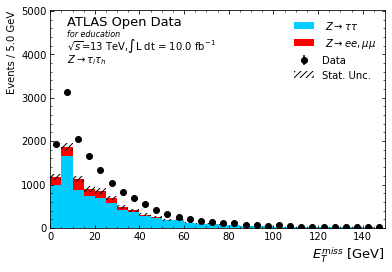

In [21]:
plot_ET_miss(data)

In [22]:
def plot_vismass(data):
    GeV = 1.0
    xmin = 0 * GeV
    xmax = 150 * GeV
    step_size = 5 * GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['data']['vis_mass']/1000., 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    #signal_x = data[r'Signal ($m_H$ = 125 GeV)']['met_et']/1000. # histogram the signal
    #signal_weights = data[r'Signal ($m_H$ = 125 GeV)'].totalWeight # get the weights of the signal events
    #signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data']: # if not data nor signal
            mc_x.append( data[s]['vis_mass']/1000. ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                      fmt='ko', # 'k' means black and 'o' is for circles 
                      label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])
    
    # plot the signal bar
    #main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
    #              weights=signal_weights, color=signal_color,
    #               label=r'Signal ($m_H$ = 125 GeV)')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r' $m_{vis}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.76, # y
             r'$Z \rightarrow \tau_{l} \tau_{h}$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend
    
    return

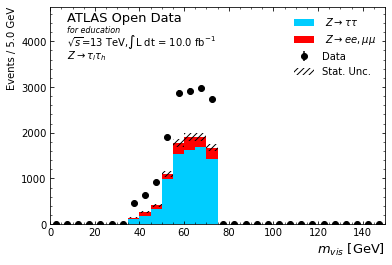

In [23]:
plot_vismass(data)

In [24]:
def plot_mT(data):
    GeV = 1.0
    xmin = 0 * GeV
    xmax = 150 * GeV
    step_size = 5 * GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['data']['mT']/1000., 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    #signal_x = data[r'Signal ($m_H$ = 125 GeV)']['met_et']/1000. # histogram the signal
    #signal_weights = data[r'Signal ($m_H$ = 125 GeV)'].totalWeight # get the weights of the signal events
    #signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data']: # if not data nor signal
            mc_x.append( data[s]['mT']/1000. ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                      fmt='ko', # 'k' means black and 'o' is for circles 
                      label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])
    
    # plot the signal bar
    #main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
    #              weights=signal_weights, color=signal_color,
    #               label=r'Signal ($m_H$ = 125 GeV)')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r' $mT$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.76, # y
             r'$Z \rightarrow \tau_{l} \tau_{h}$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend
    
    return

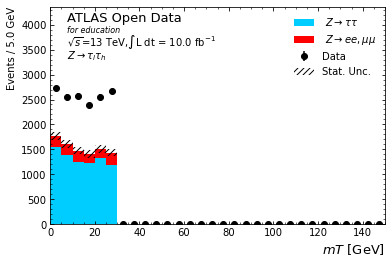

In [25]:
plot_mT(data)